In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/age-gender-and-ethnicity-face-data-csv/age_gender.csv


# Import necessary libraries

In [51]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten
import kerastuner as kt

# Read and preprocessing data

**"img_name" column is dropped because we do not need it.**


In [20]:
mydata= pd.read_csv("../input/age-gender-and-ethnicity-face-data-csv/age_gender.csv")
mydata.drop("img_name",axis=1, inplace= True)

# Visualisation for analaysing the data

**First of all, we will train and test for gender**

<AxesSubplot:xlabel='gender', ylabel='count'>

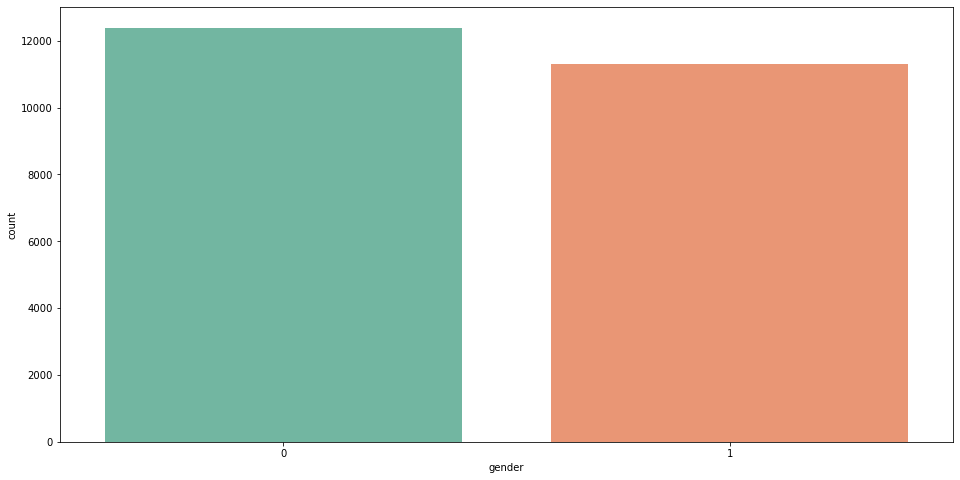

In [60]:
plt.figure(figsize=(16,8))
sns.set_palette("Set2")
sns.countplot(x ='gender', data = mydata) 

**As you see, they are almost equal, so we do not need to preprocess for the data which is gender. On the chart, "0" is labelled for man and "1" is labelled for woman.**

# Split the data like input and output

In [21]:
x= mydata.iloc[:,-1]

age= np.array([i for i in mydata["age"]],dtype="int")
ethnicity=np.array([i for i in mydata["ethnicity"]],dtype="int")
ethnicity= to_categorical(ethnicity,5)
gender= np.array([i for i in mydata["gender"]],dtype="int")
gender= to_categorical(gender,2)

# Prepare image datas(x) for training

In [22]:
img_data=[]
for i in x:
    image=np.array(i.split(" "),dtype="float32")
    image=image.reshape(48,48,1)
    img_data.append(image)
    
img_data=np.array(img_data)

In [23]:
img_data/=255
img_data= img_data.reshape(img_data.shape[0],48,48,1)

# Show random images

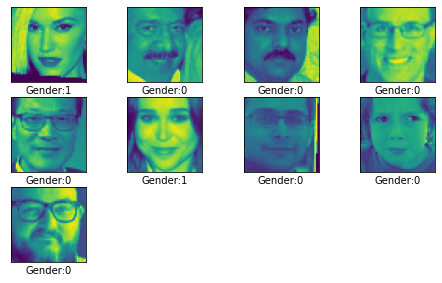

In [65]:
random_image=[random.randint(0,len(img_data)) for i in range(10)]

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, 10):
    image = img_data[random_image[i]] 
    fig.add_subplot(rows, columns, i)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)
    plt.xlabel("Gender:"+str(mydata['gender'].iloc[random_image[i]]))
plt.show()

# Split inputs and outputs like train and test

In [25]:
xtrain,xtest= train_test_split(img_data, test_size=0.33, random_state=0)

ytrain_age, ytest_age= train_test_split(age, test_size=0.33, random_state=0)
ytrain_eth, ytest_eth= train_test_split(ethnicity, test_size=0.33, random_state=0)
ytrain_gender, ytest_gender= train_test_split(gender, test_size=0.33, random_state=0)

# Create model for training

**We use keras functional API and to find the best parameters, we use keras tuner.**

In [26]:
def model_builder(hp):
    image_input= keras.Input(shape=(48,48,1))
    x= Conv2D(32, kernel_size=3, activation="relu")(image_input)
    x= Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x= MaxPooling2D(2)(x)
    x= Dropout(0.30)(x)
    hp_kernel= hp.Choice("kernel_size", values=[3,5])
    x= Conv2D(128, kernel_size=hp_kernel, activation="relu")(x)
    x= MaxPooling2D(2)(x)
    x= BatchNormalization()(x)
    x= Flatten()(x)
    x= Dense(units=128, activation= "relu")(x)
    image_output= Dense(2,activation="softmax")(x)
    model= keras.Model(image_input, image_output)
    hp_learning_rate= hp.Choice("learning_rate", values=[1e-2,1e-3]);
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])
    return model
    


In [27]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=5,
                     factor=2,
                     directory='my_dir',
                     project_name='face_age')

In [29]:
stop_early= keras.callbacks.EarlyStopping(monitor="val_loss",patience=2)

# Search for the best parameters to implement the model.

In [30]:
tuner.search(xtrain, ytrain_gender , epochs=5, validation_split=0.2, callbacks=[stop_early])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal kernel size for the third convolutional layer is {best_hps.get('kernel_size')}.
the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}. """)

Trial 9 Complete [00h 06m 37s]
val_accuracy: 0.844192624092102

Best val_accuracy So Far: 0.8901479244232178
Total elapsed time: 00h 46m 11s

The hyperparameter search is complete. The optimal kernel size for the third convolutional layer is 5.
the optimal learning rate for the optimizer is 0.001. 


In [31]:
model= tuner.hypermodel.build(best_hps)
history= model.fit(xtrain, ytrain_gender, epochs=10, validation_split= 0.2)
val_accuracy_per_epoch=history.history["val_accuracy"]
best_epoch= val_accuracy_per_epoch.index(max(val_accuracy_per_epoch))+1
print('Best epoch: %d' % (best_epoch,))


Epoch 1/10
398/398 [==============================] - 100s 250ms/step - loss: 0.4943 - accuracy: 0.7685 - val_loss: 0.4228 - val_accuracy: 0.8637
Epoch 2/10
398/398 [==============================] - 97s 245ms/step - loss: 0.3047 - accuracy: 0.8630 - val_loss: 0.3016 - val_accuracy: 0.8694
Epoch 3/10
398/398 [==============================] - 101s 253ms/step - loss: 0.2574 - accuracy: 0.8889 - val_loss: 0.3179 - val_accuracy: 0.8587
Epoch 4/10
398/398 [==============================] - 109s 275ms/step - loss: 0.2235 - accuracy: 0.9053 - val_loss: 0.2972 - val_accuracy: 0.8813
Epoch 5/10
398/398 [==============================] - 109s 274ms/step - loss: 0.2041 - accuracy: 0.9148 - val_loss: 0.2855 - val_accuracy: 0.8788
Epoch 6/10
398/398 [==============================] - 107s 268ms/step - loss: 0.1660 - accuracy: 0.9300 - val_loss: 0.3192 - val_accuracy: 0.8876
Epoch 7/10
398/398 [==============================] - 103s 258ms/step - loss: 0.1562 - accuracy: 0.9334 - val_loss: 0.3258 - 

**Keras tuner found the best parameters and epochs**

# Validation

In [33]:
hypermodel = tuner.hypermodel.build(best_hps)

hypermodel.fit(xtest, ytest_gender, epochs=best_epoch)

Epoch 1/8
245/245 [==============================] - 57s 230ms/step - loss: 0.5905 - accuracy: 0.7255
Epoch 2/8
245/245 [==============================] - 57s 231ms/step - loss: 0.3407 - accuracy: 0.8489
Epoch 3/8
245/245 [==============================] - 56s 230ms/step - loss: 0.3062 - accuracy: 0.8647
Epoch 4/8
245/245 [==============================] - 57s 231ms/step - loss: 0.2631 - accuracy: 0.8742
Epoch 5/8
245/245 [==============================] - 57s 234ms/step - loss: 0.2205 - accuracy: 0.9020
Epoch 6/8
245/245 [==============================] - 57s 232ms/step - loss: 0.2071 - accuracy: 0.9085
Epoch 7/8
245/245 [==============================] - 56s 228ms/step - loss: 0.1808 - accuracy: 0.9234
Epoch 8/8
245/245 [==============================] - 58s 236ms/step - loss: 0.1594 - accuracy: 0.9335


# Evaluate the result for gender

In [34]:
eval_result = hypermodel.evaluate(xtest, ytest_gender)


245/245 [==============================] - 12s 47ms/step - loss: 0.1141 - accuracy: 0.9516
[test loss, test accuracy]: [0.11408993601799011, 0.9515531063079834]


In [35]:
print("[test loss, test accuracy]:", eval_result)

[test loss, test accuracy]: [0.11408993601799011, 0.9515531063079834]


**As you see, we get %95 accuracy for gender when we evaluate the selected model. For better results, we can use keras tuner but it takes little bit longer.**

# Plot accuracy and loss for gender

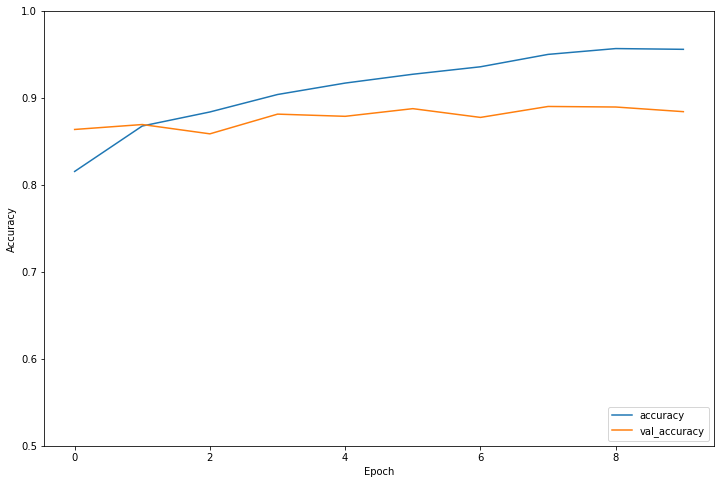

In [45]:
plt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

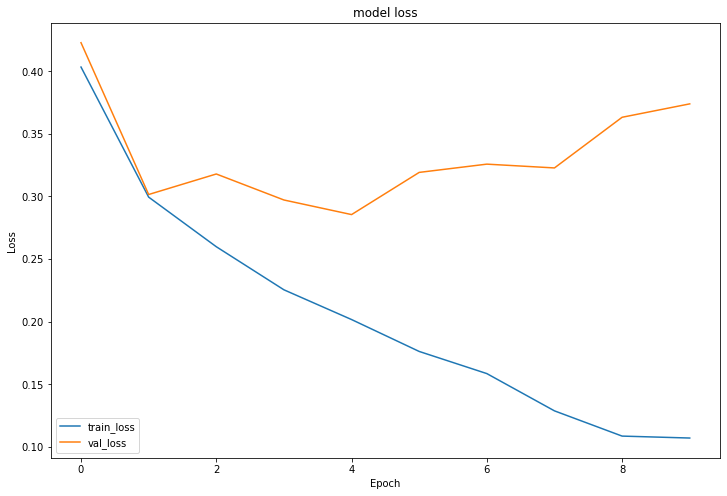

In [49]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'], loc='lower left')
plt.show()

In [61]:
print("okay")

okay
